<a href="https://colab.research.google.com/github/kkipngenokoech/MI/blob/main/data_preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget https://media.githubusercontent.com/media/kkipngenokoech/MI/refs/heads/main/smrdata.zip -O smrdata.zip


--2025-11-16 03:24:58--  https://media.githubusercontent.com/media/kkipngenokoech/MI/refs/heads/main/smrdata.zip
Resolving media.githubusercontent.com (media.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to media.githubusercontent.com (media.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1540873695 (1.4G) [application/zip]
Saving to: ‘smrdata.zip’

smrdata.zip         100%[===================>]   1.43G  25.7MB/s    in 20s     

2025-11-16 03:25:18 (73.6 MB/s) - ‘smrdata.zip’ saved [1540873695/1540873695]



In [2]:
!unzip smrdata.zip > /dev/null 2>&1
%cd smrdata


/content/smrdata


File: Session1/Session1_LRS001R01.mat
Channels (active only): 13 Samples: 185880 fs: 1000


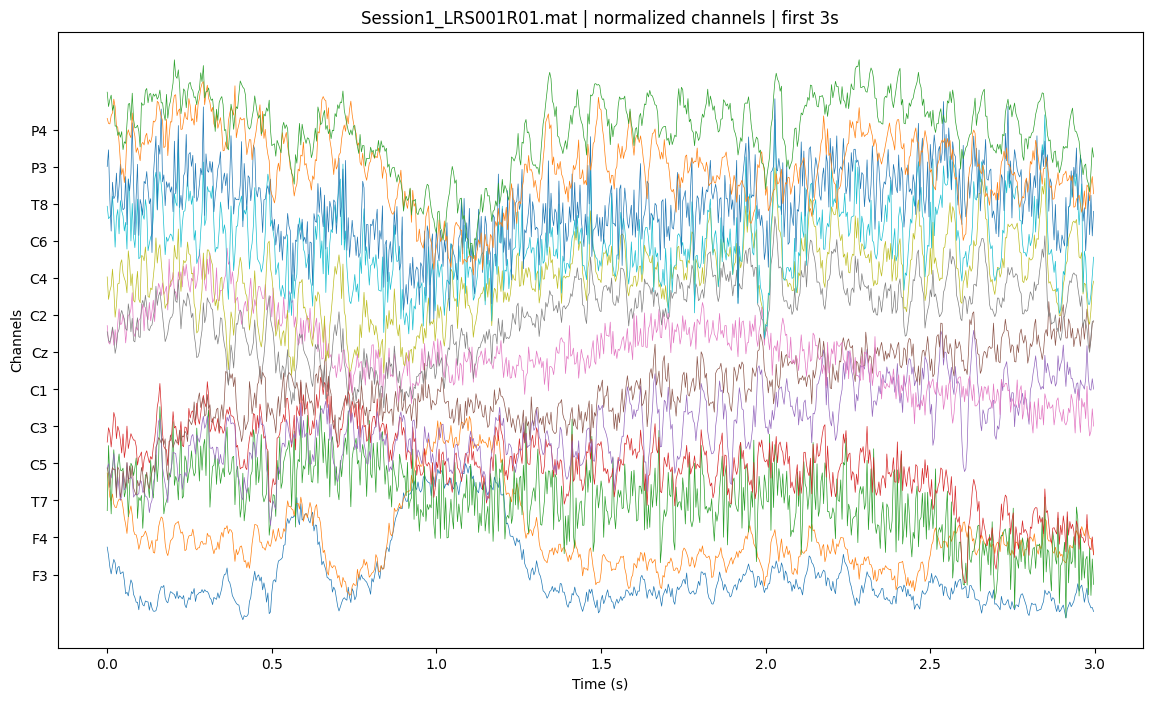

In [3]:
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import os

# ---- CONFIG ----
data_dir = "Session1"        # folder containing the .mat file
vis_seconds = 3              # how many seconds of data to plot
downsample = 4               # plot every Nth sample
offset = 400                 # vertical shift between channels (μV)
# -----------------

# pick the first .mat file automatically
files = sorted([f for f in os.listdir(data_dir) if f.endswith(".mat")])
if not files:
    raise RuntimeError("No .mat files found.")
matfile = os.path.join(data_dir, files[0])

# load
run = sio.loadmat(matfile)["runData"][0, 0]

fs = int(run["fs"][0, 0])             # sampling rate
X = run["allData"]                   # (channels, samples)

# fix labels
labels_array = run["label"]
labels = [str(l[0]) if isinstance(l, np.ndarray) else str(l) for l in labels_array.flatten()]

nch, nsamp = X.shape
assert len(labels) == nch, f"Number of labels ({len(labels)}) does not match number of channels ({nch})"

ts = run["trialStart"].flatten().astype(int)

# ---- determine range first ----
N = min(int(vis_seconds * fs), nsamp)
t = np.arange(N)[::downsample] / fs

# ---- select only active electrodes ----
active_labels = [
    'F3','F4','Fc5','Fc3','Fc1','Fcz','Fc2','Fc4','Fc6',
    'T7','C5','C3','C1','Cz','C2','C4','C6','T8',
    'Cp5','Cp3','Cp1','Cpz','Cp2','Cp4','Cp6','P3','P4'
]
active_idx = [i for i, l in enumerate(labels) if l in active_labels]

# subset data
Y = X[active_idx, :N][:, ::downsample]
labels = [labels[i] for i in active_idx]
nch = len(active_idx)

print("File:", matfile)
print("Channels (active only):", nch, "Samples:", nsamp, "fs:", fs)

# ---- plot normalized, vertically shifted signals ----
plt.figure(figsize=(14, 8))
for i in range(nch):
    y = Y[i]
    y_norm = (y - np.mean(y)) / np.std(y)  # z-score
    plt.plot(t, y_norm + i, linewidth=0.5)  # vertical shift by index

plt.xlabel("Time (s)")
plt.ylabel("Channels")
plt.yticks(range(nch), labels if nch <= 80 else [])
plt.title(f"{files[0]} | normalized channels | first {vis_seconds}s")
plt.show()
